In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow.keras as keras
from tqdm import tqdm
from google.colab import drive
import os
import cv2
import pickle
import json
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [25]:
# Check GPU available
#tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 548767539291429072, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11910626025696264642
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13966880078216969018
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16691212002516505643
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [26]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
path = "/content/drive/My Drive"
os.chdir(path)
os.listdir(path)

['Getting started.pdf',
 'daibingze-cv-new.pdf',
 'Colab Notebooks',
 'plant-pathology-2020-fgvc7',
 'VGG_history.pkl',
 'Project teams.xlsx',
 'VGG_history_aug.pkl',
 'HOGSVM.ipynb',
 'GraySVM.ipynb',
 'submission.csv']

In [28]:
submission=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/sample_submission.csv')
train=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/train.csv')
test=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/test.csv')

train.head()
test.head()
submission.head()



,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [29]:
# Load training set
train_img=[]
train_label=[]
path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype('float32')
    train_img.append(img)

# Load test set
test_img=[]
path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [01:00<00:00, 30.00it/s]


In [30]:
# Create training labels
train_label=train.loc[:,'healthy':'scab']
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

print(train_label)

print("Training set size:",train_img.shape)
print("Training label size:",train_label.shape)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Training set size: (1821, 224, 224, 3)
Training label size: (1821, 4)


In [0]:
# Image pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [32]:
# Train-val split 80-20 split. No K-fold at the moment
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1456, 224, 224, 3)
(365, 224, 224, 3)
(1456, 4)
(365, 4)


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.layers import *
from keras.models import Sequential

In [34]:
# VGG16-based model + Dense(256) + Dense(4)
base_model=InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))
base_model.trainable=False
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total params: 22,328,356
Trainable params: 525,572
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
BS = 16
EPOCHS = 30;
history_aug = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

Epoch 1/30
91/91 [==============================] - 20s 221ms/step - loss: 1.0586 - accuracy: 0.5886 - val_loss: 54.0666 - val_accuracy: 0.2712
Epoch 2/30
91/91 [==============================] - 15s 162ms/step - loss: 0.8142 - accuracy: 0.6944 - val_loss: 41.7503 - val_accuracy: 0.2658
Epoch 3/30
91/91 [==============================] - 16s 170ms/step - loss: 0.7770 - accuracy: 0.7067 - val_loss: 82.8223 - val_accuracy: 0.2712
Epoch 4/30
91/91 [==============================] - 16s 173ms/step - loss: 0.7479 - accuracy: 0.7308 - val_loss: 47.4497 - val_accuracy: 0.2685
Epoch 5/30
91/91 [==============================] - 16s 171ms/step - loss: 0.7627 - accuracy: 0.7170 - val_loss: 54.0331 - val_accuracy: 0.2712
Epoch 6/30
91/91 [==============================] - 16s 171ms/step - loss: 0.7752 - accuracy: 0.7088 - val_loss: 61.3698 - val_accuracy: 0.2740
Epoch 7/30
91/91 [==============================] - 16s 171ms/step - loss: 0.7478 - accuracy: 0.7157 - val_loss: 87.6484 - val_accuracy:

In [36]:
import tensorflow.keras as keras
base_model.trainable=True
model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
BS = 16
EPOCHS = 70;
history_aug = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

Epoch 1/70
91/91 [==============================] - 38s 415ms/step - loss: 0.5604 - accuracy: 0.8008 - val_loss: 0.7675 - val_accuracy: 0.7534
Epoch 2/70
91/91 [==============================] - 22s 242ms/step - loss: 0.4757 - accuracy: 0.8297 - val_loss: 0.5059 - val_accuracy: 0.8082
Epoch 3/70
91/91 [==============================] - 23s 252ms/step - loss: 0.4273 - accuracy: 0.8475 - val_loss: 0.4542 - val_accuracy: 0.8521
Epoch 4/70
91/91 [==============================] - 23s 253ms/step - loss: 0.3955 - accuracy: 0.8633 - val_loss: 0.4190 - val_accuracy: 0.8575
Epoch 5/70
91/91 [==============================] - 23s 249ms/step - loss: 0.3373 - accuracy: 0.8757 - val_loss: 0.3929 - val_accuracy: 0.8630
Epoch 6/70
91/91 [==============================] - 23s 247ms/step - loss: 0.3154 - accuracy: 0.8908 - val_loss: 0.3892 - val_accuracy: 0.8548
Epoch 7/70
91/91 [==============================] - 22s 247ms/step - loss: 0.3021 - accuracy: 0.8935 - val_loss: 0.3570 - val_accuracy: 0.8767

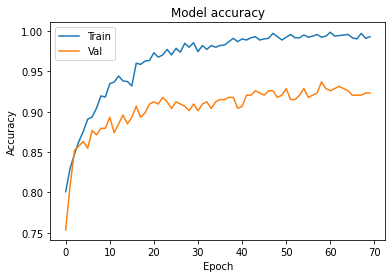

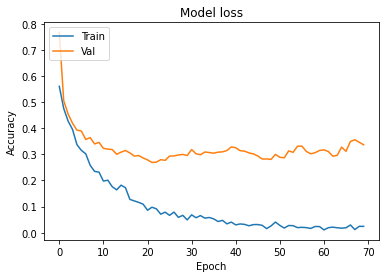

In [37]:
# Plot training loss and accuracy
history = history_aug
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')





In [38]:
model.summary()
layer_outputs = [layer.output for layer in model.layers[0].layers]

# visualize_model = Model(inputs = model.layers[0].layers[0].input, outputs=layer_outputs)
# #visualize_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 1028      
Total params: 22,328,356
Trainable params: 22,293,924
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
# from numpy import expand_dims
# train_img.shape
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# img = expand_dims(img, axis=0)
# img.shape
# feature_maps = visualize_model.predict(img)
# feature_maps[1].shape

# # plot all 64 maps in an 8x8 squares
# plt.figure()
# from PIL import Image
# img_img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
# plt.imshow(img_img)

# # plt.figure()
# idx = 1
# fig, axes = plt.subplots(nrows=4, ncols=16)
# for ax in axes.flat:
#     im = ax.imshow(feature_maps[17][0, :, :, idx-1], cmap='viridis')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     idx+=1
# fig.colorbar(im, ax=axes.ravel().tolist())
# fig.set_figheight(8)
# fig.set_figwidth(32)
# # plt.suptitle('Hidden Layer Activation')

In [0]:
# def featVisualization(visualize_model, img):
#     from numpy import expand_dims
#     from PIL import Image
#     img = expand_dims(img, axis=0)
#     img.shape
#     feature_maps = visualize_model.predict(img)
#     feature_maps[1].shape

#     # plot all 64 maps in an 8x8 squares
#     plt.figure()
#     img_img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
#     plt.imshow(img_img)

#     # plt.figure()
#     idx = 1
#     fig, axes = plt.subplots(nrows=4, ncols=16)
#     for ax in axes.flat:
#         im = ax.imshow(feature_maps[17][0, :, :, idx-1], cmap='viridis')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         idx+=1
#     fig.colorbar(im, ax=axes.ravel().tolist())
#     fig.set_figheight(8)
#     fig.set_figwidth(32)

In [0]:
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# featVisualization(visualize_model, img)

In [0]:
# Save training results
# f = open("./results/VGG_history_aug.pkl","wb")
# pickle.dump(history.history,f)
# f.close()

In [0]:
#  Load old training results
# new_history = pickle.load( open( "./results/VGG_history.pkl", "rb" ) )


In [0]:
# submission
y_pred = model.predict(test_img)


submission.loc[:,'healthy':'scab'] = y_pred
submission.to_csv('submissiongooglef.csv',index = False)

In [0]:
# PLot confusion matrix

val_pred = model.predict(X_val)

In [50]:
pred_index = np.argmax(val_pred,1)
y_val_index = np.argmax(y_val,1)
type(pred_index)

numpy.ndarray

In [51]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_val_index, pred_index)

array([[ 96,   1,   0,   2],
       [  2,   8,   3,   6],
       [  1,   1, 116,   2],
       [  7,   3,   0, 117]])